# Load saved model

In [8]:
%matplotlib inline
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = load_model('cnn_delta_80_640.h5')

In [3]:
data = np.load('test_delta_data.npy')

In [4]:
data.shape

(200, 80, 640, 1)

In [68]:
# sum check to validate data ranges captured on android are reasonable
for i in range(10):
    print(data[i].sum())

372.745800316
899.832209662
406.149265751
737.379130699
249.187574193
193.182421505
172.206661142
384.40218436
326.344386555
325.30083555


In [6]:
blank = np.zeros([1, 80, 640, 1])
blank.shape

(1, 80, 640, 1)

In [7]:
model.predict(blank)

array([[ 0.33621463]], dtype=float32)

In [31]:
data[1].max()

0.62945097684860229

## Test images that will be used to validate android tf implementation
These images will be loade donto the android app and fed into the tensorflow model in the same way the captured images will be. This confirm that the pixel matrix is being un-rolled as expected when fed into the CNN. 
**I'm being carful to send the images saved by this notebook back into the tensorflow model to get our base score, this is becuase when they were intially saved the `imsave()` function scaled the greyscale values to have a max of 1.**

In [24]:
from scipy.misc import imsave,imread

## Saving the images

[[ 0.38704374]]


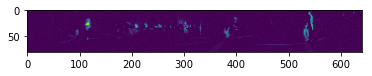

[[ 0.69471133]]


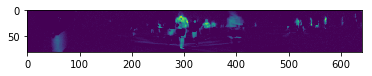

[[ 0.33988523]]


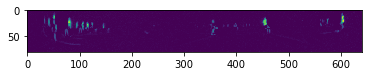

[[ 0.81504261]]


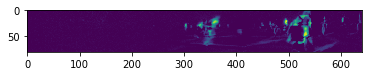

[[ 0.87772053]]


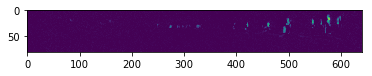

In [23]:
for i,f in enumerate(data[:5]):
    print(model.predict(f.reshape([1,80, 640, 1])))
    img = f.reshape([80, 640])
    plt.imshow(img)
    imsave(arr=img,name='test_images/{0}.png'.format(i))
    plt.show()

In [42]:
data[1].max()

0.62945097684860229

In [56]:

(test_out/405.1).max()

0.62947420390027153

In [57]:
model.predict((test_out/405.1).reshape([1,80, 640, 1]))

array([[ 0.69551247]], dtype=float32)

## Loading the images back in to get the base predictions
Notice that even though these images are the same as above, they have different predictions, this is becuase when they were saved their value were scaled to have a max of 255.

[[ 0.66692114]]


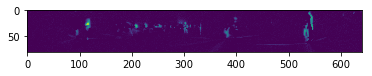

[[ 1.06887317]]


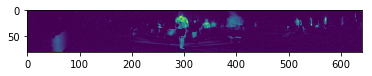

[[ 0.48625368]]


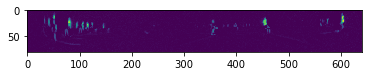

[[ 1.42884064]]


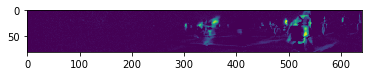

[[ 1.54279304]]


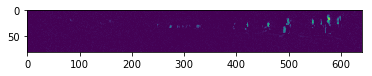

In [65]:
for i in range(5):
    test_out = imread('test_images/{0}.png'.format(i))
    pred_img = test_out/255
    print(model.predict(pred_img.reshape([1,80, 640, 1])))
    plt.imshow(pred_img)
    plt.show()

In [67]:
test_out.min(),test_out.max()

(0, 255)

In [9]:
model.predict(data[:10])

array([[ 0.38704374],
       [ 0.69471163],
       [ 0.33988512],
       [ 0.81504452],
       [ 0.87772077],
       [ 0.79350603],
       [ 0.18234229],
       [ 0.6766603 ],
       [ 0.52408177],
       [ 0.95730448]], dtype=float32)

In [6]:
from keras import backend as K

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [7]:
def export_model(saver, model, MODEL_NAME, input_node_names = None, output_node_name = None):
    
    if input_node_names is None:
        input_node_names = [x.op.name for x in model.inputs]
    if output_node_name is None:
        output_node_name = [x.op.name for x in model.outputs][0]
        
    print(input_node_names)
    print(output_node_name)
    
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

save the model like the following:
```
export_model(tf.train.Saver(), model, ["conv2d_1_input"], "dense_2/Softmax")
```

In [8]:
# K.set_learning_phase(1)

In [10]:
export_model(tf.train.Saver(), model, 'cnn_delta_80_640_graph')

['input_input']
output/BiasAdd
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
39 ops in the final graph.
graph saved!


In [11]:
model.count_params()

12741921